In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import vgg16

In [ ]:
# Transformations for the input images (grayscale)
transform_input = transforms.Compose([
    #--------------------------------- # Convert to grayscale
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Transformations for the target images (color)
transform_target = transforms.Compose([
    transforms.ToTensor(),
])

# test is a tensor , should be pil image, write transform object for test


# Custom dataset class
class ColorizationDataset(Dataset):
    def __init__(self, dataset, transform_input=None, transform_target=None, isTest=False):
        self.dataset = dataset
        self.transform_input = transform_input
        self.transform_target = transform_target

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        input_image, _ = self.dataset[idx]
        target_image = input_image

        if self.transform_input:
            input_image = self.transform_input(input_image)

        if self.transform_target:
            target_image = self.transform_target(target_image)

        return input_image, target_image

# Load CIFAR-10 dataset
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_target)

# Splitting train dataset into train and validation
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset_full, [40000, 10000])

# Apply transformations and create DataLoader for train, validation, and test sets
train_loader = DataLoader(ColorizationDataset(train_dataset, transform_input, transform_target), batch_size=32, shuffle=True)


validation_loader = DataLoader(ColorizationDataset(validation_dataset, transform_input, transform_target), batch_size=32, shuffle=False)
test_loader = DataLoader(ColorizationDataset(test_dataset, transform_input, transform_target), batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [12:44<00:00, 222929.71it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [35]:
# Define an iterator for the test_loader
test_loader_iter = iter(test_loader)

# Get the first instance from the iterator
first_instance = next(test_loader_iter)

# Print the first instance
print(first_instance)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [ ]:
test_dataset[0] # should be pil image

(<PIL.Image.Image image mode=RGB size=32x32>, 4)

# U-net structure

In [4]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    """U-Net model with skip connections (Residuals)."""
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # --- ENCODER ---
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # --- BOTTLENECK ---
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        
        # --- DECODER ---
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),  # 512 + 512 (residual) = 1024 input channels
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),  # 256 + 256 (residual) = 512 input channels
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  # 128 + 128 (residual) = 256 input channels
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 64 + 64 (residual) = 128 input channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Final layer
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # --- ENCODER ---
        enc1 = self.enc1(x) #  
        enc2 = self.enc2(self.pool(enc1))  # (32x32) -> (16x16)
        enc3 = self.enc3(self.pool(enc2))  # (16x16) -> (8x8) 
        enc4 = self.enc4(self.pool(enc3))  # (8x8)   -> (4x4) 
        
        # --- BOTTLENECK ---
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # --- DECODER + SKIP CONNECTIONS ---
        x = self.up4(bottleneck)
        x = torch.cat([x, enc4], dim=1)
        dec4 = self.dec4(x)
        
        x = self.up3(dec4)
        x = torch.cat([x, enc3], dim=1)
        dec3 = self.dec3(x)
        
        x = self.up2(dec3)
        x = torch.cat([x, enc2], dim=1)
        dec2 = self.dec2(x)
        
        x = self.up1(dec2)
        x = torch.cat([x, enc1], dim=1)
        dec1 = self.dec1(x)
        
        # --- FINAL LAYER ---
        return self.final(dec1)


In [39]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, target in tqdm(dataloader):
        images, target = images.to(device), target.to(device).squeeze(dim=1).to(torch.float)  # mask shape becomes [N, H, W]
        
        outputs = model(images)  
        # print(outputs.shape)
        # print(target.shape)
        
        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    # print(-1)
    with torch.no_grad():
        for images, target in dataloader:
            # print(0)
            images, target = images.to(device), target.to(device).to(torch.long)    
            # print(1)
            outputs = model(images)  
            # print(2)
            loss = criterion(outputs, target)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [40]:
import torch

# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(in_channels=1, out_channels=3).to(device)  # Output channels = 3 classes 

In [41]:

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

num_epochs = 10  # Define number of epochs
train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, validation_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


100%|██████████| 1250/1250 [02:00<00:00, 10.33it/s]


Epoch 1/10: Train Loss = 0.0114, Val Loss = 0.2718


100%|██████████| 1250/1250 [02:01<00:00, 10.32it/s]


Epoch 2/10: Train Loss = 0.0063, Val Loss = 0.2705


100%|██████████| 1250/1250 [02:01<00:00, 10.33it/s]


Epoch 3/10: Train Loss = 0.0060, Val Loss = 0.2681


100%|██████████| 1250/1250 [02:01<00:00, 10.33it/s]


Epoch 4/10: Train Loss = 0.0058, Val Loss = 0.2686


100%|██████████| 1250/1250 [02:00<00:00, 10.34it/s]


Epoch 5/10: Train Loss = 0.0056, Val Loss = 0.2774


100%|██████████| 1250/1250 [02:01<00:00, 10.33it/s]


Epoch 6/10: Train Loss = 0.0053, Val Loss = 0.2762


100%|██████████| 1250/1250 [02:01<00:00, 10.33it/s]


Epoch 7/10: Train Loss = 0.0051, Val Loss = 0.2701


100%|██████████| 1250/1250 [02:00<00:00, 10.34it/s]


Epoch 8/10: Train Loss = 0.0050, Val Loss = 0.2782


100%|██████████| 1250/1250 [02:00<00:00, 10.33it/s]


Epoch 9/10: Train Loss = 0.0048, Val Loss = 0.2754


100%|██████████| 1250/1250 [02:01<00:00, 10.32it/s]


Epoch 10/10: Train Loss = 0.0046, Val Loss = 0.2763


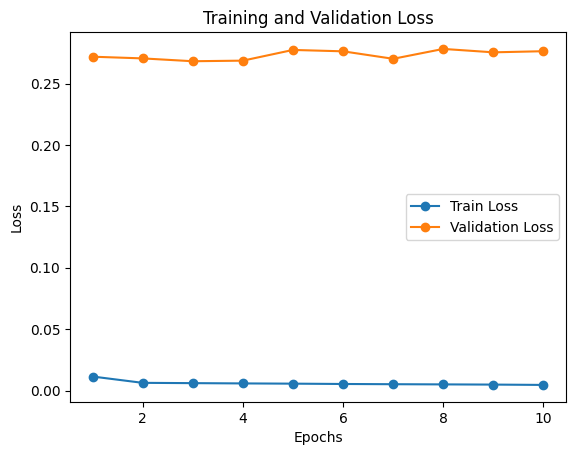

In [42]:
### **🔹 Plot Training Loss Curve**
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


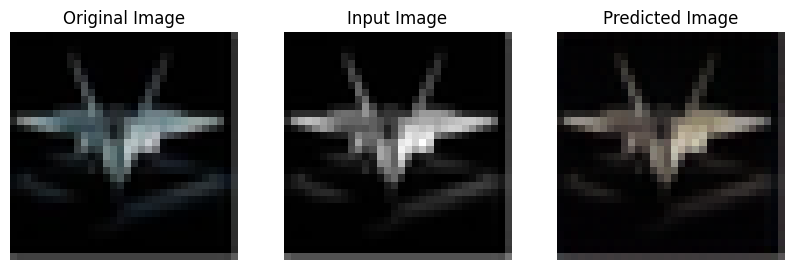

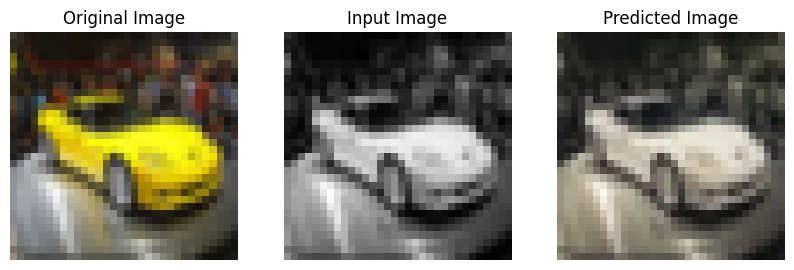

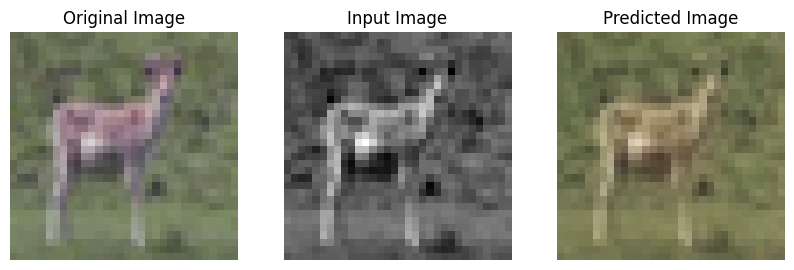

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


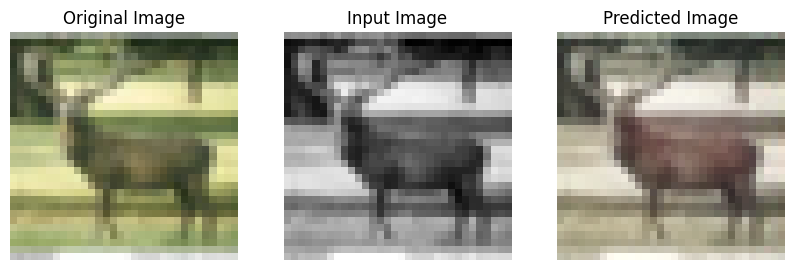

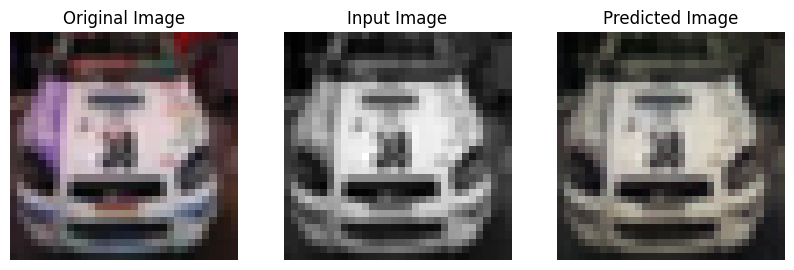

In [51]:
import random
import matplotlib.pyplot as plt
transform_test = transforms.Compose([
    # input is in tensor
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])
model.eval()
# Get some test samples
test_samples = random.sample(range(len(test_dataset)), 5)

for idx in test_samples:
    img, cls_id = test_dataset[idx]
    input_img = transform_test(img) 
    with torch.no_grad():
        pred_img = model(input_img.unsqueeze(0).to(device))  # Forward pass
    # plot the img, input_img, pred_img
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(img.permute(1, 2, 0).numpy())
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    axs[1].imshow(input_img[0], cmap='gray')
    axs[1].set_title("Input Image")
    axs[1].axis('off')
    axs[2].imshow(pred_img[0].cpu().numpy().transpose(1, 2, 0))
    axs[2].set_title("Predicted Image")
    axs[2].axis('off')
    plt.show()

